<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Binary-classification-example" data-toc-modified-id="Binary-classification-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Binary classification example</a></span></li></ul></div>

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as d
from numpy import ma
from scipy.stats import norm

%matplotlib notebook

In [2]:
N = 30000
n = 1000
mu, std = 10, 3

# Population
population = np.random.normal(10, 3, N)

# Sample
X = population[np.random.randint(0, N, n)]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.hist(
    X,
    bins=35,
)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title(f"Sampling distribution")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Sampling distribution')

In [3]:
def prior(params):
    if params[1] <= 0:
        return 0
    return 1


def plt_dynamic(x, y, ax, colors=['b']):
    ax.scatter(x[0], y[0], c='r', s=2)
    for color in colors:
        ax.scatter(x[1:], y[1:], c='k', s=1)
    ax.set_xlabel(r'$\mu$', fontsize=14)
    ax.set_ylabel(r'$\sigma$', fontsize=14)
    ax.set_title(f'Current $\mu$: {x[-1]:.5f}, $\sigma$: {y[-1]:.5f}',
                 fontsize=14)
    fig.canvas.draw()


def H(params, rs, X):
    return U(params, X) + K(rs)


def U(params, X):
    mu, sigma = params[0], params[1]
    return -np.log(ma.masked_equal(norm(mu, sigma).pdf(X), 0)).sum() - np.log(prior(params))


def K(rs):
    rs = rs.reshape(1, -1)
    return 1 / 2 * np.sum(rs @ np.eye(2) @ rs.T)


def del_U(params, X):
    mu, sigma = params[0], params[1]
    grad_mu = -(X - mu).sum() / (sigma**2)
    grad_sigma = -(((X - mu)**2).sum() / (sigma**3) - len(X) * (1 / sigma))

    return np.array([grad_mu, grad_sigma])


def HMC(X, ini_params=np.array([0.1, 1]), num_iter=500, m=1000, eps=1e-5):
    params_t = np.array(ini_params)
    n_params = len(ini_params)
    accepted = []
    for t in range(num_iter):
        rs_t = np.random.normal(size=n_params)
        params_0, rs_0 = params_t.copy(), rs_t.copy()
        rs_0 = rs_0 - eps / 2 * del_U(params_0, X)
        params_i = params_0
        rs_i = rs_0
        for _ in range(m):
            params_i += eps * rs_i
            rs_i -= eps * del_U(params_i, X)
        params_m = params_i
        rs_m = rs_i - eps / 2 * del_U(params_m, X)

        params_hat = params_m
        rs_hat = rs_m
        # MH correction
        u = np.random.uniform()
        rho = np.exp(H(params_hat, rs_hat, X) - H(params_t, rs_t, X))

        if u < min(1, rho):
            params_t = params_hat
            accepted.append(params_t)
            if not t % 100:
                print(
                    f'Iteration {t:>5} | μ: {params_t[0]:.4f} | σ: {params_t[1]:.4f}'
                )
    return accepted

In [4]:
X.mean(), X.std()

(9.978245185780512, 3.023234562341184)

In [5]:
ini_mu = 15.
ini_sigma = 2.
ini_params = np.array([ini_mu, ini_sigma])
num_iter = 1000
accepted = HMC(X, ini_params, num_iter)

Iteration     0 | μ: 14.9420 | σ: 2.1874
Iteration   100 | μ: 13.1438 | σ: 4.0987
Iteration   200 | μ: 12.4100 | σ: 4.1286
Iteration   300 | μ: 11.6805 | σ: 3.8540
Iteration   400 | μ: 11.1684 | σ: 3.6435
Iteration   500 | μ: 10.6818 | σ: 3.4829
Iteration   600 | μ: 10.4548 | σ: 3.3531
Iteration   700 | μ: 10.0815 | σ: 3.1973
Iteration   800 | μ: 9.9982 | σ: 3.1058
Iteration   900 | μ: 9.9971 | σ: 3.0340


<IPython.core.display.Javascript object>


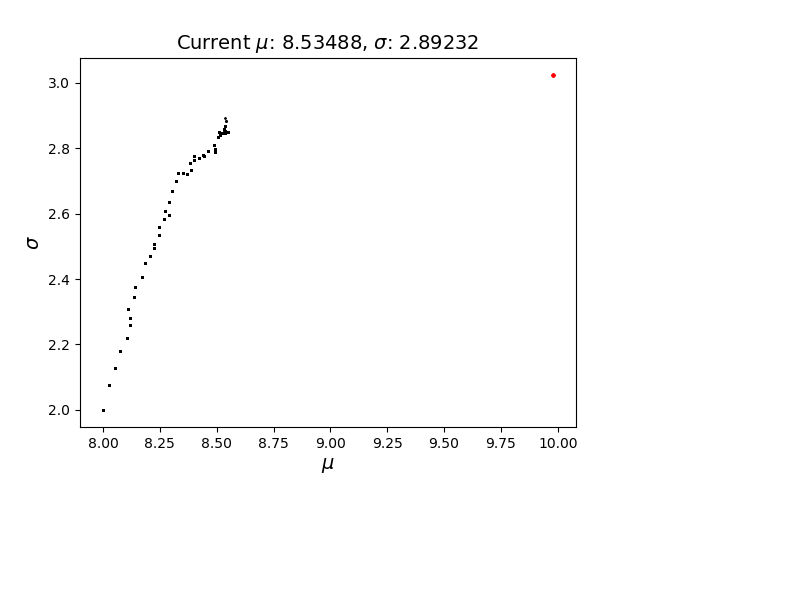

In [6]:
ini_mu = 8.
ini_sigma = 2.
ini_params = np.array([ini_mu, ini_sigma])
eps = 1e-5
num_iter = 50
m = 1000

params_t = np.array(ini_params)
n_params = len(ini_params)
xs = [X.mean(), ini_params[0]]
ys = [X.std(), ini_params[1]]
fig, ax = plt.subplots(1, 1)
plt_dynamic(xs, ys, ax)
for t in range(num_iter):
    rs_t = np.random.normal(size=n_params)
    params_0, rs_0 = params_t.copy(), rs_t.copy()
    rs_0 = rs_0 - eps / 2 * del_U(params_0, X)
    params_i = params_0
    rs_i = rs_0
    for _ in range(m):
        params_i += eps * rs_i
        rs_i -= eps * del_U(params_i, X)
    params_m = params_i
    rs_m = rs_i - eps / 2 * del_U(params_m, X)

    params_hat = params_m
    rs_hat = rs_m
    # MH correction
    u = np.random.uniform()
    rho = np.exp(H(params_hat, rs_hat, X) - H(params_t, rs_t, X))

    if u < min(1, rho):
        params_t = params_hat
        if not t % 1:
            # rint(params_t)
            xs.append(params_t[0])
            ys.append(params_t[1])
            plt_dynamic(xs, ys, ax)

## Binary classification example

In [46]:
import pandas as pd
data = pd.read_csv('banknote.txt', header=None).replace('?', pd.NA)
# .dropna()

In [47]:
from sklearn.model_selection import train_test_split

data = data.dropna().values.astype(float)
X, y = data[:,:-1], (data[:, -1] > 0.5).astype(float)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [219]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def prior(params):
    a, b = 1, 2
    return a / (2 * ((b**2)**0.5)) * np.exp(-a * np.abs(params) / ((b**2)**0.5))


def del_prior(params):
    a, b = 1, 2
    output = -(a**2 * ((params**2)**0.5) * np.exp(-a * ((params**2)**0.5) / ((b**2)**0.5))) / (2 * b**2 * params)
    return output


def H(X, y, params, rs, M_inv):
    return U(X, y, params) + K(rs, M_inv)


def K(rs, M_inv):
    return 1 / 2 * np.sum(rs @ M_inv @ rs.T)


def U(X, y, params):
    return -(np.log(sigmoid(X[y == 1] @ params)).sum() +
             np.log(1 - sigmoid(X[y == 0] @ params)).sum() +
             np.log(prior(params)).sum())


def del_U(X, y, params, scale=1):
    return -(scale * ((y[:, None] - sigmoid(X @ params)).T @ X).flatten() +
             del_prior(params).flatten())


def V(X, y, params):
    return np.cov((((y[:, None] - sigmoid(X @ params)).T) * X.T))


def hmc(X, y, M, penalty='l1', max_iter=500, m=1000, eps=1e-5, verbose=False):
    n_params = X.shape[1]
    params_t = np.random.normal(size=(n_params, 1))
    accepted = []
    M_inv = np.linalg.inv(M)
    rs = multivariate_normal(np.zeros(n_params), M, size=(max_iter, 1))
    us = np.random.uniform(size=(max_iter))
    for t in range(max_iter):
        params_i, r_i = params_t.copy(), rs[t].copy()
        r_i = r_i - eps / 2 * del_U(X, y, params_i)
        for _ in range(m):
            params_i += eps * (M_inv @ r_i.T)
            r_i -= eps * del_U(X, y, params_i)
        r_i = r_i - eps / 2 * del_U(X, y, params_i)

        # MH correction
        rho = np.exp(
            H(X, y, params_i, r_i, M_inv) - H(X, y, params_t, rs[t], M_inv))
        if us[t] < min(1, rho):
            params_t = params_i
            accepted.append(params_t)

        if verbose:
            if not t % 100:
                print(f'Iteration {t:>5}' + ''.join(f'| {p:>7.4f}' for p in params_t.flatten()))
    est_params = np.r_[accepted][int(max_iter * .7):].mean(axis=0)

    return est_params


def sghmc(X, y, M,
          batch_size=16, penalty='l1', max_iter=500,
          m=1000, eps=1e-5, verbose=False):
    n_samples, n_params = X.shape[0], X.shape[1]
    scale = n_samples / batch_size
    params = np.random.normal(size=n_params).reshape(-1, 1)
    M_inv = np.linalg.inv(M)
    rs = multivariate_normal(np.zeros(n_params), M, size=(max_iter, 1))
    batch_ids = np.random.choice(range(n_samples), size=(max_iter, batch_size))
    for t in range(max_iter):
        batch_X, batch_y = X[batch_ids[t]], y[batch_ids[t]]
        for _ in range(m):
            params += eps * (M_inv @ rs[t].T)
            B_hat = 1 / 2 * eps * V(batch_X, batch_y, params)
            C = B_hat
            if eps > 1e-3:
                rs[t] -= (eps * del_U(batch_X, batch_y, params, scale=scale) +
                          eps * (C @ (M_inv @ rs[t].T)).flatten() -
                          multivariate_normal(np.zeros(n_params), 2 * (C - B_hat) * eps))
            else:
                rs[t] -= (eps * del_U(batch_X, batch_y, params, scale=n_samples / batch_size) +
                          eps * (C @ (M_inv @ rs[t].T)).flatten())
        if verbose:
            if not t % 100:
                print(f'Iteration {t:>5}' + ''.join(f'| {p:>7.4f}'
                                                    for p in params.flatten()))

    return params

In [220]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from numpy.random import multivariate_normal


class BayesianLogisticRegression(ClassifierMixin, BaseEstimator):
    """
    Bayesian Logistic Regression.
    """
    def __init__(self, penalty='l2', tol=1e-4,
                 fit_intercept=True, class_weight=None,
                 random_state=None, solver='hmc', max_iter=100,
                 multi_class='auto', verbose=0, n_jobs=None,
                 batch_size=64, available_solvers=('hmc', 'sghmc')):

        self.penalty = penalty
        self.tol = tol
        self.fit_intercept = fit_intercept
        self.class_weight = class_weight
        self.random_state = random_state
        self.solver = solver
        self.max_iter = max_iter
        self.multi_class = multi_class
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.batch_size = batch_size
        self.available_solvers = available_solvers

    def fit(self, X, y, M='I'):

        X, y = check_X_y(X, y)

        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y

        if self.fit_intercept:
            self.X_ = np.insert(self.X_, 0, 1, 1)

        if M == 'I':
            self.M = np.eye(self.X_.shape[1])
        
        assert self.solver in self.available_solvers , f'Please use available solvers: {available_solvers}'
        if self.solver == 'hmc':
            self.parameters_ = hmc(self.X_,
                                   self.y_,
                                   self.M,
                                   max_iter=self.max_iter,
                                   m=400,
                                   eps=1e-4,
                                   verbose=self.verbose)
        elif self.solver =='sghmc':
            self.parameters_ = sghmc(self.X_,
                                     self.y_,
                                     self.M,
                                     batch_size=self.batch_size,
                                     max_iter=self.max_iter,
                                     m=100,
                                     eps=1e-3,
                                     verbose=self.verbose)
        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)

        if self.fit_intercept:
            X_ = np.insert(X, 0, 1, 1)

        y_prob = self.sigmoid(X_ @ self.parameters_).flatten()
        
        return y_prob
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) > threshold).astype(int)
    
    def predict_log_prob(self, X):
        return np.log(self.predict_proba(X))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [224]:
%%time
model = BayesianLogisticRegression(max_iter=50, verbose=0, solver='hmc')
model.fit(X_train, y_train)
model.score(X_val, y_val)

CPU times: user 6.65 s, sys: 43 ms, total: 6.69 s
Wall time: 838 ms


0.9927536231884058

In [222]:
%%time
model = BayesianLogisticRegression(max_iter=50, verbose=0, solver='sghmc', batch_size=64)
model.fit(X_train, y_train)
model.score(X_val, y_val)

CPU times: user 386 ms, sys: 0 ns, total: 386 ms
Wall time: 385 ms


0.9927536231884058

In [223]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

CPU times: user 30.6 ms, sys: 0 ns, total: 30.6 ms
Wall time: 4.67 ms


0.9927536231884058